In [2]:
import pandas as pd
import numpy as np

## Setting Data

## Post-Process Data

In [3]:
raw_data = pd.read_csv("./many_people_sim_result.csv")
data_range = [int(min(raw_data['Timestamp'])), int(max(raw_data['Timestamp']) + 1)]

In [165]:
user_position_list = {}
for i in range(data_range[0], data_range[1]):
    filtered_data = data[(data['Timestamp'] >= i) & (data['Timestamp'] < i + 1)]
    dropped_filtered_data = filtered_data.drop_duplicates(subset='UUID', keep='first')

    for index, row in dropped_filtered_data.iterrows():
        user_position_list[row['UUID']] = {row['Timestamp']:[row['x'], row['y'], row['z']]}

In [166]:
i = 13680
filtered_data = data[(data['Timestamp'] >= i) & (data['Timestamp'] < i + 1)]
dropped_filtered_data = filtered_data.drop_duplicates(subset='UUID', keep='first')
print(dropped_filtered_data.shape)
dropped_filtered_data

(0, 5)


,UUID,Timestamp,x,y,z


### Filter Duplicate People

In [4]:
filtered_duplicate_people_data = []
for i in range(data_range[0], data_range[1]):
    filtered_data = raw_data[(raw_data['Timestamp'] >= i) & (raw_data['Timestamp'] < i + 1)]
    dropped_filtered_data = filtered_data.drop_duplicates(subset='UUID', keep='first')
    filtered_duplicate_people_data.append(dropped_filtered_data)
filtered_duplicate_people_pd_data = pd.concat(filtered_duplicate_people_data)
# filtered_duplicate_people_pd_data

In [7]:
# by chatgpt1
filtered_duplicate_people_data = filtered_duplicate_people_pd_data.copy()
filtered_duplicate_people_data.sort_values(by='Timestamp', inplace=True)

# 各タイムスタンプのデータでループ処理
for t in filtered_duplicate_people_data['Timestamp'].unique()[1:]:  # 最初のタイムスタンプを除くすべてのタイムスタンプ
    current = filtered_duplicate_people_data[filtered_duplicate_people_data['Timestamp'] == t]
    previous = filtered_duplicate_people_data[filtered_duplicate_people_data['Timestamp'] < t].drop_duplicates(subset='UUID', keep='last')
    
    # 各現在の位置に対して最も近い前の位置を見つける
    for idx, row in current.iterrows():
        min_dist = float('inf')
        closest_uuid = None
        
        for p_idx, p_row in previous.iterrows():
            dist = np.sqrt((p_row['x'] - row['x'])**2 + (p_row['y'] - row['y'])**2 + (p_row['z'] - row['z'])**2)
            if dist < min_dist:
                min_dist = dist
                closest_uuid = p_row['UUID']
        
        # 距離が閾値（例えば0.5メートル）以下なら同じUUIDを割り当てる
        if min_dist <= 0.5:
            filtered_duplicate_people_data.at[idx, 'UUID'] = closest_uuid

# 結果の確
print(filtered_duplicate_people_data)

                                  UUID  Timestamp        x         y         z
0     8ba004c922a9b7f4b9da8c4b63ccae8d  13680.050 -3.93169 -3.001080  0.532280
9     984917491cbf7b7feb65d794fee57dc7  13680.851 -4.42574 -0.521871  0.073672
12    8ba004c922a9b7f4b9da8c4b63ccae8d  13681.051 -3.87624 -2.991800  0.530911
13    984917491cbf7b7feb65d794fee57dc7  13681.051 -4.41836 -0.514856  0.084565
22    5802b79d83f62e57829800b866624a83  13681.451 -4.96861 -2.082820  0.042470
...                                ...        ...      ...       ...       ...
2456  2888ba9268cad29cc7d84fded625fcaa  13723.009 -7.06929 -1.155150  0.129709
2457  eb7c0b20350bd21e0b7d101522abcf30  13723.009 -6.05053 -2.129090  0.145877
2458  88171658a61ffb50ec58050bfc0bf665  13723.009 -6.53425 -2.773960  0.146122
2459  8ba004c922a9b7f4b9da8c4b63ccae8d  13723.009 -4.01424 -3.131510  0.092928
2461  251da309aa9ce0f33cefe0ce06cb2cf2  13723.009 -4.99236 -3.604180  0.302438

[367 rows x 5 columns]


In [36]:
# by chatgpt2
filtered_duplicate_people_data = filtered_duplicate_people_pd_data.copy()

# 検出されないフレームを許容する時間間隔（例：30秒）
time_threshold = 2
speed = 1.0 # [m/s]
distance_threshold = speed * time_threshold

# タイムスタンプと位置情報でデータをソート
filtered_duplicate_people_data.sort_values(by=['Timestamp', 'x', 'y', 'z'], inplace=True)

# 各データポイントをチェックしてUUIDを更新
for index, current_row in filtered_duplicate_people_data.iterrows():
    # 前のタイムスタンプのデータをチェック
    mask = (filtered_duplicate_people_data['Timestamp'] < current_row['Timestamp']) & (filtered_duplicate_people_data['Timestamp'] >= current_row['Timestamp'] - time_threshold)
    previous_data = filtered_duplicate_people_data[mask]
    
    if not previous_data.empty:
        # 最も近いデータポイントを見つける
        previous_data['distance'] = np.sqrt((previous_data['x'] - current_row['x'])**2 + (previous_data['y'] - current_row['y'])**2 + (previous_data['z'] - current_row['z'])**2)
        closest_point = previous_data.loc[previous_data['distance'].idxmin()]
        
        # 閾値内で最も近い点があるか確認
        if closest_point['distance'] < distance_threshold:  # 位置が1メートル以内であれば同一と見なす
            filtered_duplicate_people_data.at[index, 'UUID'] = closest_point['UUID']

# 結果の確認
print(filtered_duplicate_people_data)

/tmp/ipykernel_3837223/3015555882.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_data['distance'] = np.sqrt((previous_data['x'] - current_row['x'])**2 + (previous_data['y'] - current_row['y'])**2 + (previous_data['z'] - current_row['z'])**2)


                                  UUID  Timestamp        x         y         z
0     8ba004c922a9b7f4b9da8c4b63ccae8d  13680.050 -3.93169 -3.001080  0.532280
9     984917491cbf7b7feb65d794fee57dc7  13680.851 -4.42574 -0.521871  0.073672
13    984917491cbf7b7feb65d794fee57dc7  13681.051 -4.41836 -0.514856  0.084565
12    8ba004c922a9b7f4b9da8c4b63ccae8d  13681.051 -3.87624 -2.991800  0.530911
22    8ba004c922a9b7f4b9da8c4b63ccae8d  13681.451 -4.96861 -2.082820  0.042470
...                                ...        ...      ...       ...       ...
2458  8ba004c922a9b7f4b9da8c4b63ccae8d  13723.009 -6.53425 -2.773960  0.146122
2457  8ba004c922a9b7f4b9da8c4b63ccae8d  13723.009 -6.05053 -2.129090  0.145877
2460  8ba004c922a9b7f4b9da8c4b63ccae8d  13723.009 -5.52840 -1.196250  0.206273
2461  8ba004c922a9b7f4b9da8c4b63ccae8d  13723.009 -4.99236 -3.604180  0.302438
2459  8ba004c922a9b7f4b9da8c4b63ccae8d  13723.009 -4.01424 -3.131510  0.092928

[367 rows x 5 columns]


In [37]:
data = filtered_duplicate_people_data.copy()

### Filter Measured Area

In [12]:
map_range = {'x': [-7, -3], 'y': [2, 7]}
map_range = {'x': [-14, -6], 'y': [0, 6]}
map_filtered_data = data[
    (data['x'] > map_range['x'][0]) & (data['x'] < map_range['x'][1]) &
    (data['y'] > map_range['y'][0]) & (data['y'] < map_range['y'][1])
]

In [13]:
filtered_data = map_filtered_data

In [14]:
data = filtered_data.copy()

### Load PCD Map

In [20]:
import open3d as o3d
import matplotlib.pyplot as plt

In [17]:
map_pcd = o3d.io.read_point_cloud("./map/many_people_sim_map.pcd")
map_pcd_nparray = np.asarray(map_pcd.points)

In [18]:
map_x, map_y = [], []
for map_point in map_pcd_nparray:
    if (map_point[2] > 1 and map_point[2] < 1.2):
        map_x.append(map_point[0])
        map_y.append(map_point[1])

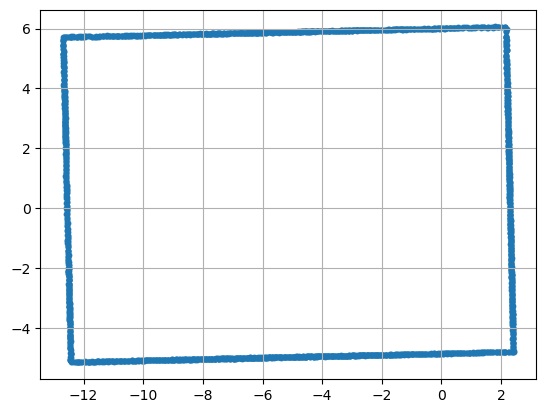

In [21]:
fig, ax = plt.subplots()
ax.scatter(map_x, map_y, s=10)
ax.grid()
plt.show()

## Visualize Data

In [22]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ArtistAnimation
from IPython.display import HTML

In [38]:
fig, ax = plt.subplots()


UUID_color_dict = {}
color_idx = 0

map_scatter = ax.scatter(map_x, map_y, s=10)

frames = []

for i in range(data_range[0], data_range[1]):
    filtered_data = data[(data['Timestamp'] >= i) & (data['Timestamp'] < i + 1)]
    dropped_filtered_data = filtered_data.drop_duplicates(subset='UUID', keep='first')

    artists = []
    for index, row in dropped_filtered_data.iterrows():
        if (row['UUID'] not in UUID_color_dict):
            UUID_color_dict[row['UUID']] = f'C{color_idx}'
            color_idx += 1
        artist = ax.plot((1) * row['x'], (1) * row['y'], '.', c=UUID_color_dict[row['UUID']])
        artists.extend(artist)

         # 色の名前をテキストとして表示
        text_artist = ax.text(row['x'] + 0.1, row['y'], UUID_color_dict[row['UUID']], fontsize=8, color=UUID_color_dict[row['UUID']])
        artists.append(text_artist)
        
    print(f"Time {i} : the num of people is {dropped_filtered_data.shape[0]}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    
    title = ax.text(0.5, 1.01, f"Timestamp : {i}", ha='center', va='bottom', transform=ax.transAxes, fontsize='large')
    artists.append(title)
   
    artists.append(map_scatter)
    
    frames.append(artists)
print(f"The num of measured people is {len(UUID_color_dict)}")
ani = ArtistAnimation(fig, frames, interval = 1000)
ani.save('./animation.mp4', writer="ffmpeg")
plt.close()

Time 13680 : the num of people is 2
Time 13681 : the num of people is 2
Time 13682 : the num of people is 2
Time 13683 : the num of people is 2
Time 13684 : the num of people is 2
Time 13685 : the num of people is 2
Time 13686 : the num of people is 2
Time 13687 : the num of people is 2
Time 13688 : the num of people is 2
Time 13689 : the num of people is 2
Time 13690 : the num of people is 2
Time 13691 : the num of people is 2
Time 13692 : the num of people is 2
Time 13693 : the num of people is 2
Time 13694 : the num of people is 2
Time 13695 : the num of people is 2
Time 13696 : the num of people is 2
Time 13697 : the num of people is 2
Time 13698 : the num of people is 2
Time 13699 : the num of people is 2
Time 13700 : the num of people is 2
Time 13701 : the num of people is 2
Time 13702 : the num of people is 2
Time 13703 : the num of people is 2
Time 13704 : the num of people is 2
Time 13705 : the num of people is 2
Time 13706 : the num of people is 2
Time 13707 : the num of peop